# QSVM 手寫數字辨識教學（Qiskit + sklearn）

本 Notebook 以 **QSVM（Quantum Support Vector Machine）** 的典型做法：
- 用 **量子特徵映射電路（feature map）** 把資料編碼成量子態  ∣ϕ(x)⟩
- 用 **fidelity** 定義量子 kernel：

  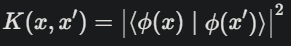
- 計算出 **kernel matrix** 後，交給 **classical SVM** 做分類

為了讓同學在 **Google Colab** 順利跑完，我們使用 `sklearn digits (8×8)` 資料集，先做最常見且容易理解的 **二元分類：0 vs 1**。


## 1️⃣ 安裝套件（Colab）




In [28]:
!pip -q install "qiskit>=1.0" qiskit-aer qiskit-machine-learning scikit-learn matplotlib pylatexenc

## 2️⃣ 匯入必要函式庫
我們會用：
- `sklearn`：資料集、PCA、SVM、評估指標
- `qiskit` / `qiskit-machine-learning`：feature map 與 quantum kernel


In [29]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel


## 3️⃣ 載入手寫數字資料（digits）
### 為什麼不用 MNIST？
MNIST 是 28×28=784 維；而 QSVM 需要計算兩兩相似度形成 kernel matrix（約 \(O(N^2)\)）。
教學上若直接用 MNIST 會非常慢、也容易超時。

因此先用 `sklearn digits`（8×8=64 維）示範，**概念完全一樣**。

In [30]:
#從sklearn載入手寫數字資料集（digits dataset）
digits = load_digits()
#這個資料集裡面有很多張「手寫數字圖片」，每張是 8×8 的灰階圖（像素值 0~16 左右）。

X_raw = digits.data
y_raw = digits.target

print("原始資料 X shape:", X_raw.shape, "y shape:", y_raw.shape)
print("labels:", np.unique(y_raw))
# (1797, 64)  每張 8×8 => 64 維向量,共1797張圖
# 資料有0到9

原始資料 X shape: (1797, 64) y shape: (1797,)
labels: [0 1 2 3 4 5 6 7 8 9]


## 4️⃣ 選擇分類任務：0 vs 1（二元分類）
### 為什麼先做二元分類？
多類別（0~9）常用 OvR/OvO，但計算 kernel matrix 的成本會更高、實作也更繁瑣。
先從最典型的 0 vs 1 開始：
- 好跑
- 好解釋
- 結果也通常不錯


In [31]:
#對每一筆資料，看它的 label 是不是 0 或 1如果是，就標記 True；不是就 False。
mask = (y_raw == 0) | (y_raw == 1)
#只保留 mask 為 True 的那些樣本
X = X_raw[mask]
y = y_raw[mask]

print("二元分類後 X shape:", X.shape)
print("labels:", np.unique(y))

二元分類後 X shape: (360, 64)
labels: [0 1]


## 5️⃣ 顯示幾張樣本圖
把 64 維向量 reshape 回 8×8，就能看到影像。

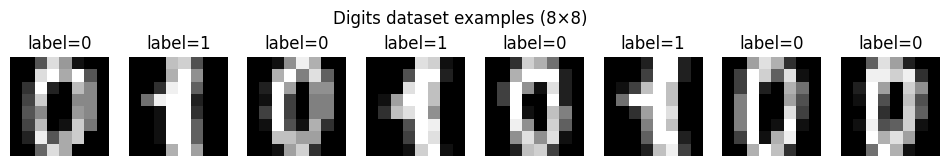

In [32]:
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(8, 8), cmap="gray")
    ax.set_title(f"label={y[i]}")
    ax.axis("off")
plt.suptitle("Digits dataset examples (8×8)")
plt.show()

## 6️⃣ 數據預處理（Scaling + PCA）
### 為什麼需要 PCA？
量子 feature map 通常假設：
- **qubit 數 = 特徵維度**

原始影像有 64 維，直接用 64 qubits 在模擬器上會非常慢。
因此我們用 PCA 降到 `n_qubits` 維（例如 6 或 8），保留主要資訊。

### 為什麼把資料縮放到 [0, π]？
因為 feature map 常用旋轉門（例如 RZ/RY），角度若落在合理區間，數值表現通常更穩定。

In [33]:
n_qubits = 8   # 建議先 6 或 8，太大會變慢

# 1) 把 pixel data 縮放到 [0, 1]
X01 = MinMaxScaler().fit_transform(X)

# 2) PCA 降到 n_qubits 維
pca = PCA(n_components=n_qubits, random_state=0)
Xp = pca.fit_transform(X01)

# 3) 再縮放到 [0, π]，方便當旋轉角度
Xp = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(Xp)

# 分割 train/test
X_train, X_test, y_train, y_test, X_train_raw, X_test_raw = train_test_split(
    Xp, y, X, test_size=0.25, random_state=0, stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (270, 8) X_test: (90, 8)


## 7️⃣ 建構量子特徵映射電路（Quantum Feature Map）
QSVM 的精神：**不是直接用量子電路輸出類別**，而是用量子電路定義一個 kernel。

這裡用最常見的 `ZZFeatureMap`：
- 每個特徵會進入電路（角度編碼）
- 透過 ZZ 交互作用產生糾纏
- `reps` 控制層數（越大越慢，也不一定越好）

In [34]:
#從 Qiskit 內建電路庫中，匯入一個現成的特徵映射電路：ZZFeatureMap。
from qiskit.circuit.library import ZZFeatureMap
#實際建立一個 feature map 電路，並指定它的結構。
feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2, entanglement="linear")
#reps為層數

/tmp/ipython-input-944462872.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2, entanglement="linear")


In [35]:
from qiskit.circuit.library import zz_feature_map

feature_map = zz_feature_map(
    feature_dimension=n_qubits,
    reps=1,
    entanglement="linear"
)


In [36]:
feature_map.decompose().draw("mpl", fold=100)
plt.show()


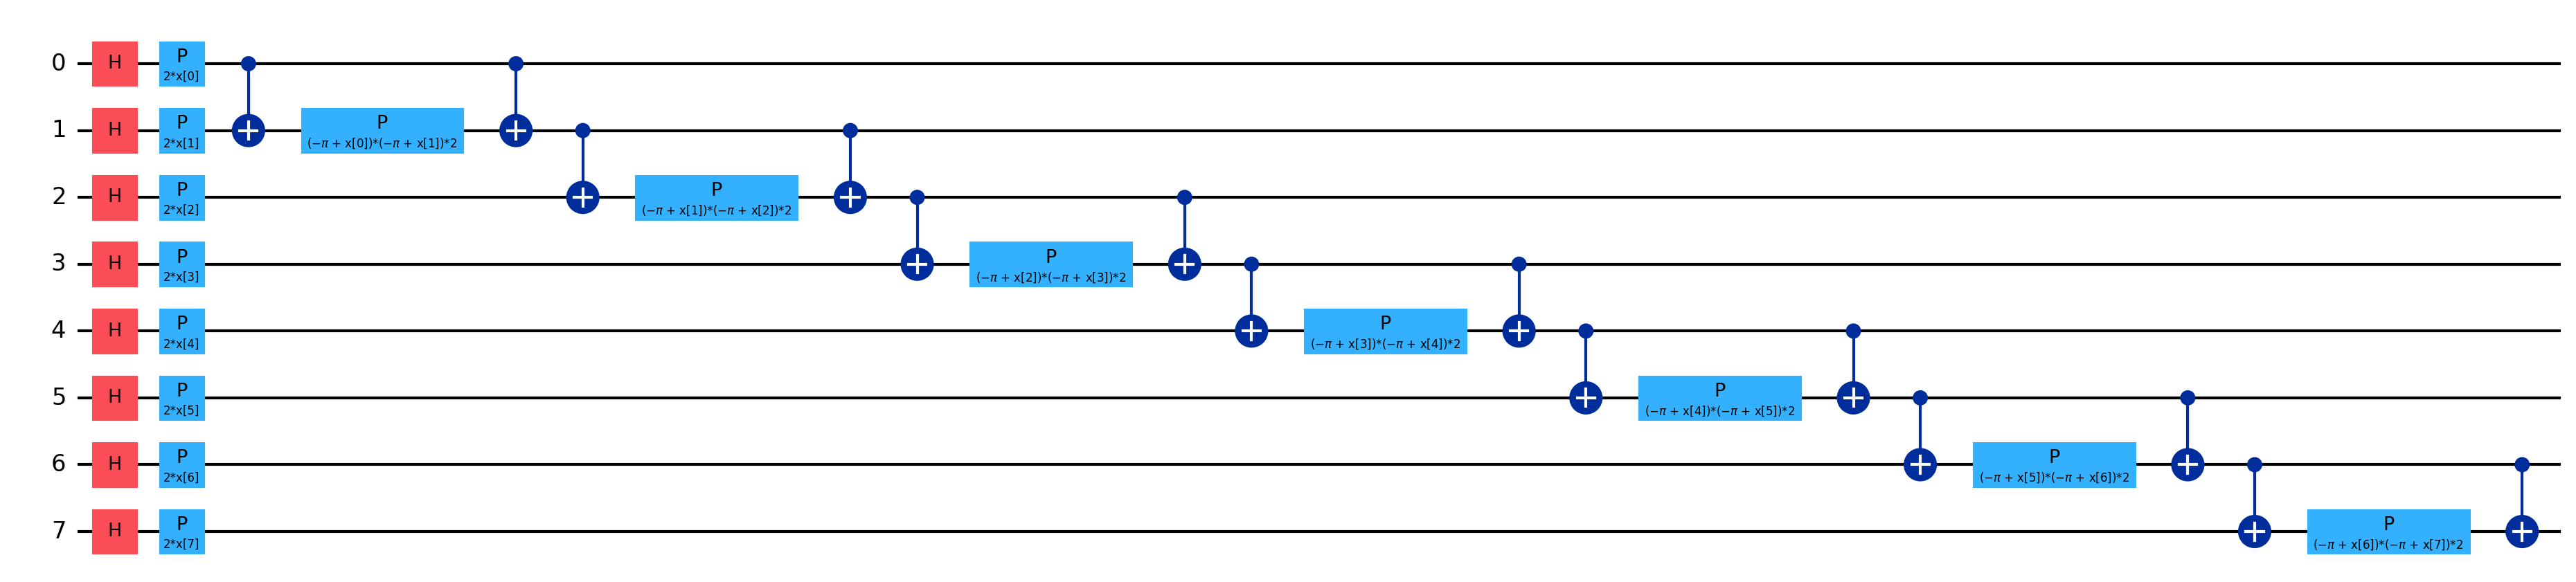

In [37]:
#ZZ feature map電路圖
from IPython.display import Image, display

path = "feature_map.png"
feature_map.draw(output="mpl", fold=120, filename=path)

display(Image(filename=path))


## 8️⃣ 建立 Quantum Kernel（FidelityStatevectorKernel）
###  `FidelityStatevectorKernel`的定義如下:
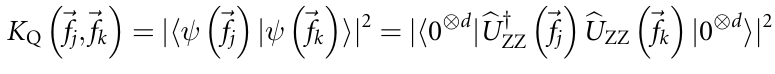

也就是將我們剛剛所構成的ZZ feature map作用在我們的qubites上具體的電路如下:

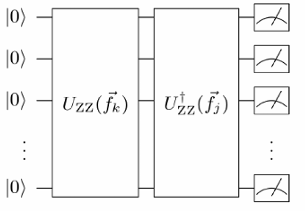

以此我們就可以構成我們的矩陣Kernel Matrix如下:

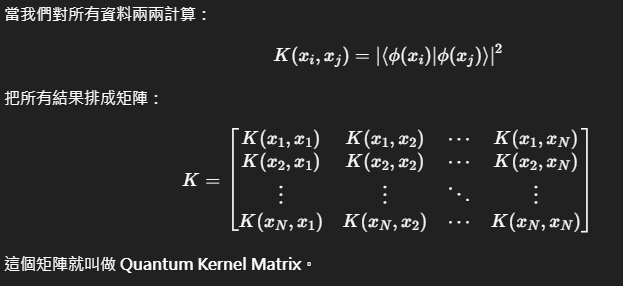

這個矩陣「每一格」代表第 i 筆資料 與 第 j 筆資料
在「量子特徵空間」中的相似度。

接近 1 → 非常像

接近 0 → 幾乎不相似

In [38]:
qkernel = FidelityStatevectorKernel(feature_map=feature_map)
#計算「訓練資料彼此之間」的量子 kernel matrix
K_train = qkernel.evaluate(X_train)           # (N_train, N_train)

#計算「測試資料 對 訓練資料」的量子 kernel matrix
K_test  = qkernel.evaluate(X_test, X_train)   # (N_test,  N_train)

#確認矩陣維度
print("K_train:", K_train.shape, "K_test:", K_test.shape)

K_train: (270, 270) K_test: (90, 270)


## 9️⃣ QSVM：用 kernel matrix 訓練  SVM
`sklearn.svm.SVC` 支援 precomputed kernel：
- 設定 `kernel='precomputed'`
- 直接把 K_train/K_test 丟進去

這樣就完成 QSVM。

In [39]:
#我們不讓 SVM 自己算 kernel，而是「直接餵給它 kernel matrix」


clf = SVC(kernel="precomputed", C=1.0) #C=1.0是正則化參數，用來控制：分類錯誤的懲罰程度邊界的平滑程度

#用訓練資料的 kernel matrix + 標籤 來訓練 SVM
clf.fit(K_train, y_train)

#根據「測試資料與訓練資料的相似度」，預測每一筆測試資料屬於哪一類。
y_pred = clf.predict(K_test)

#比較：真實標籤 y_test預測標籤 y_pred算出分類正確率（Accuracy）。
acc = accuracy_score(y_test, y_pred)
print("QSVM Accuracy:", acc)


QSVM Accuracy: 0.8666666666666667


## 🔟 結果評估：報告 + 混淆矩陣

如果我們將1 當作正類為例：

1. Precision （精確率）看的是在所有被模型判成 1 的樣本中，有幾個是真的 1算式如下:

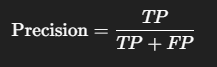

2.Recall 看的是在所有真的 1 裡面，有多少被模型成功找出來算式如下:

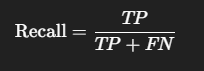

3.因為 Precision 和 Recall 常常會互相拉扯：

模型很保守 → Precision 高、Recall 低

模型很積極 → Recall 高、Precision 低

只看其中一個會失真，所以用 F1-score 把兩者綜合起來。

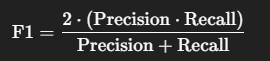

所以0當正類是類似的邏輯

Macro Average每一類別都當成同樣重要，先各自算指標，再取平均P為每個編號的機率

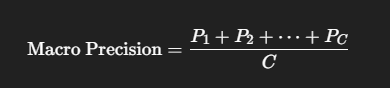

Weighted Average比起Macro Average多考慮了樣本數量

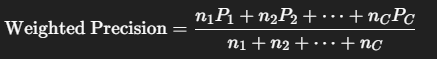

TN (True Negative)
真的是 0 → 預測成 0

FP (False Positive)
真的是 0 → 被誤判成 1

FN (False Negative)
真的是 1 → 被誤判成 0

TP (True Positive)
真的是 1 → 預測成 1

In [40]:
print(classification_report(y_test, y_pred, digits=4))
#support為測試集中的數量0與1分別是45個

              precision    recall  f1-score   support

           0     0.8667    0.8667    0.8667        45
           1     0.8667    0.8667    0.8667        45

    accuracy                         0.8667        90
   macro avg     0.8667    0.8667    0.8667        90
weighted avg     0.8667    0.8667    0.8667        90



## 1️⃣1️⃣ 結果圖 ①：混淆矩陣熱圖
在二元分類時，confusion matrix 長這樣:

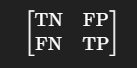

TN (True Negative)
真的是 0 → 預測成 0

FP (False Positive)
真的是 0 → 被誤判成 1

FN (False Negative)
真的是 1 → 被誤判成 0

TP (True Positive)
真的是 1 → 預測成 1

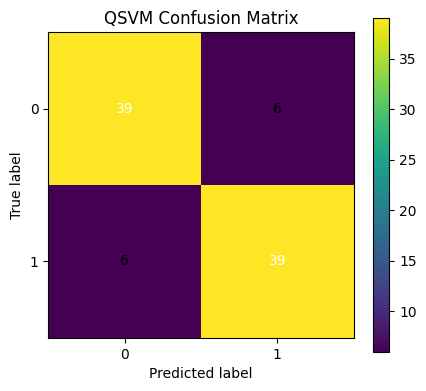

In [41]:
cm = confusion_matrix(y_test, y_pred)
classes = ["0", "1"]

plt.figure(figsize=(4.5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("QSVM Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

## 1️⃣2️⃣ 結果圖 ②：Quantum Kernel Matrix 熱圖
Quantum Kernel Matrix 熱圖是在顯示：
每一筆資料與其他所有資料之間的「量子相似度」。

顏色越亮 → 越像

顏色越暗 → 越不像


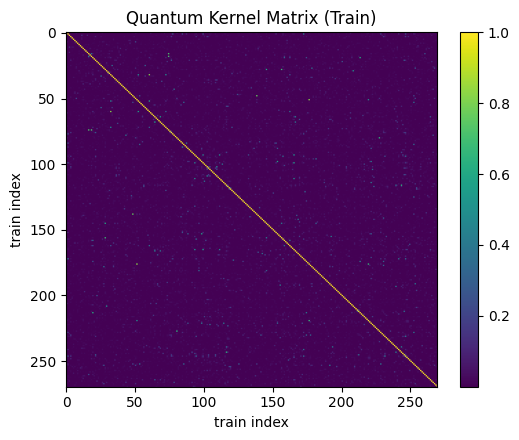

In [42]:
plt.figure(figsize=(5.5, 4.5))
plt.imshow(K_train, aspect="auto")
plt.colorbar()
plt.title("Quantum Kernel Matrix (Train)")
plt.xlabel("train index")
plt.ylabel("train index")
plt.tight_layout()
plt.show()

## 1️⃣3️⃣ 預測樣本可視化



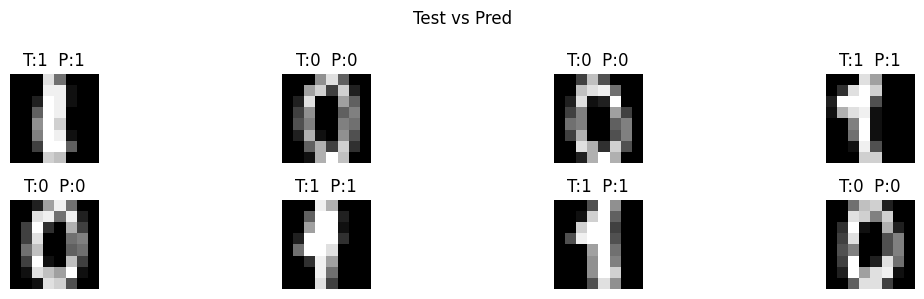

In [43]:
ture_idx = np.where(y_pred == y_test)[0]
n_show = min(8, len(ture_idx))

plt.figure(figsize=(12, 3))
for k in range(n_show):
    i = ture_idx[k]
    plt.subplot(2, 4, k+1)
    plt.imshow(X_test_raw[i].reshape(8, 8), cmap="gray")
    plt.title(f"T:{y_test[i]}  P:{y_pred[i]}")
    plt.axis("off")

plt.suptitle("Test vs Pred")
plt.tight_layout()
plt.show()